In [1]:
# !pip install PIMS
# !pip install trackpy
# !pip install pandas==1.5.3
# !pip install opencv-python
# !pip install plotly

In [2]:
# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

import numpy as np
import pandas as pd

import pims
import trackpy as tp
import os

import cv2

import matplotlib  as mpl 
import matplotlib.pyplot as plt 
import plotly.express as px

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(15, 12)) #(10, 6)
mpl.rc('image', cmap='gray')

In [3]:
# to read standard files, including tiff stacks, we can use pims.open
my_img = pims.open('tiff_series_processed_10test/*.tif')

In [4]:
my_img

<Frames>
Source: /Users/miroshni/Documents/Unifr/Unifr_work/glass_transition_in_emulsions/TrackPy/microgels/feb20/S5/tiff_series_processed_10test/*.tif
Length: 21 frames
Frame Shape: (128, 512)
Pixel Datatype: uint8

In [5]:
my_img.shape

(21, 128, 512)

In [6]:
from stardist.models import StarDist2D, Config2D
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label
from csbdeep.utils import normalize
import matplotlib.pyplot as plt

In [7]:
# prints a list of available models
StarDist2D.from_pretrained()

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None


In [8]:
# define a pretrained model to segment nuclei in fluorescence images (download from pretrained)
model = StarDist2D.from_pretrained('2D_versatile_fluo') # 2D_versatile_he

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


(-0.5, 511.5, 127.5, -0.5)

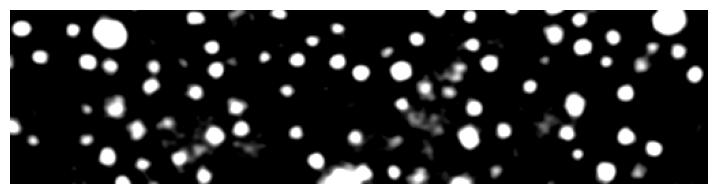

In [9]:
plt.figure(figsize=(9, 6))
plt.imshow(my_img[0], cmap='gray')
plt.axis('off')

In [10]:
@pims.pipeline
def stardist_segm(img):
#     img = cv2.resize(img, None, fx = 2, fy = 2)
    img_labels, img_details = model.predict_instances(normalize(img, 1.0, 99.8), prob_thresh=0.8, nms_thresh=0.8)
    return img_labels

In [11]:
label_image = stardist_segm(my_img)

In [12]:
label_image

(ImageSequence,) processed through proc_func. Original repr:
    <Frames>
    Source: /Users/miroshni/Documents/Unifr/Unifr_work/glass_transition_in_emulsions/TrackPy/microgels/feb20/S5/tiff_series_processed_10test/*.tif
    Length: 21 frames
    Frame Shape: (128, 512)
    Pixel Datatype: uint8

Text(0.5, 1.0, 'prediction + input overlay')

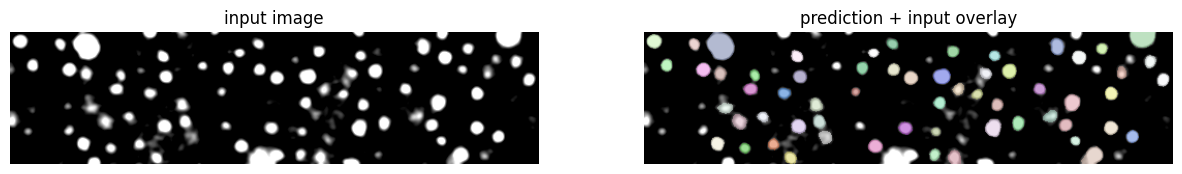

In [13]:
img_num = 1

plt.subplot(1, 2, 1)
plt.imshow(my_img[img_num], cmap='gray')
plt.axis('off')
plt.title('input image')

plt.subplot(1, 2, 2)
plt.imshow(render_label(label_image[img_num], img=my_img[img_num]))
# plt.imshow(he_labels)
plt.axis('off')
plt.title('prediction + input overlay')

In [14]:
import skimage

In [15]:
%%time
features = pd.DataFrame()

for num, img in enumerate(my_img):
    for region in skimage.measure.regionprops(label_image[num], intensity_image=img):
        # store fuatures
        dataset = pd.DataFrame({
            'y': [region.centroid[0]],
            'x': [region.centroid[1]],
            'frame': [num],
            'area': [region.area],
            'brightness': [region.intensity_mean],
        })
        
        features = pd.concat([features, dataset])
        
#         features = features.append([{'y': region.centroid[0],
#                                     'x': region.centroid[1],
#                                     'frame': num,
#                                     'area': region.area,
#                                     },])

CPU times: user 8.08 s, sys: 2.24 s, total: 10.3 s
Wall time: 1.41 s


In [16]:
features.head

<bound method NDFrame.head of              y           x  frame   area  brightness
0   121.480769  141.634615      0  104.0  205.519231
0    72.085938  339.953125      0  128.0  203.320312
0   101.559322  471.796610      0  118.0  212.483051
0    88.495327  361.859813      0  107.0  202.971963
0    38.254545  239.890909      0  110.0  215.036364
..         ...         ...    ...    ...         ...
0     6.659341   44.835165     20   91.0  207.791209
0    26.087719  186.649123     20   57.0  190.298246
0   122.768519   80.425926     20  108.0  221.898148
0     3.818182  238.147727     20   88.0  216.022727
0   119.312500  302.625000     20   80.0  150.687500

[1279 rows x 5 columns]>

In [17]:
features.to_csv('data_out/feb20_S5.csv.zip', compression='gzip', index=False)

In [18]:
# read 'features' from file 

# features = pd.read_csv('data_out/feb20_S4.csv.zip', compression='gzip')
# features.head

In [17]:
# create copy of features to make modifications
features_modif = features.copy()

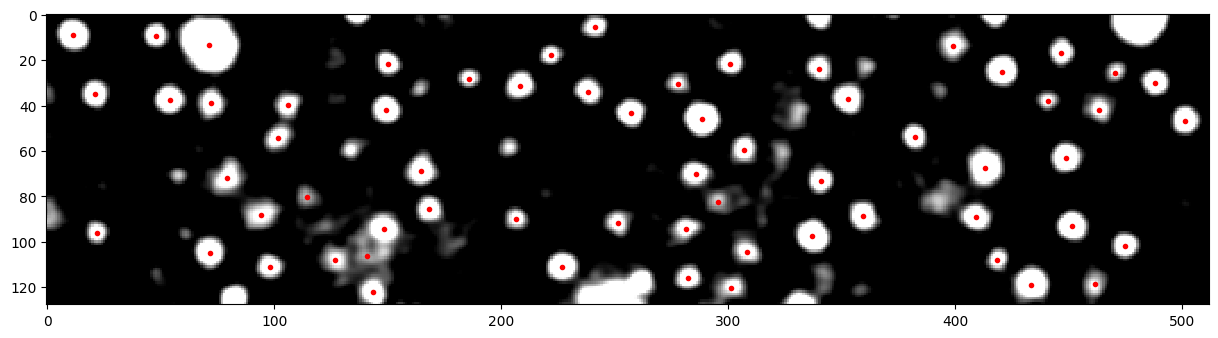

In [18]:
tp.annotate(features_modif[features_modif.frame==(9)], my_img[9], plot_style={'markersize':2});


In [19]:
# plot object areas to investigate the distribution. You can further filter out objects based on size or intensity. Not

fig = px.histogram(features_modif['area'], nbins=20, template="simple_white")

fig.show()

In [20]:
# filter out by area (make the histogram looks more or less normal distrubution)

features_modif = features_modif.loc[(features_modif['area'] > 50) & (features_modif['area'] < 219)]

In [21]:
# plot new histogram

fig = px.histogram(features_modif['area'], nbins=20, template="simple_white")

fig.show()

In [22]:
# plot the brightness (called as 'mass' in trackpy)

fig = px.histogram(features_modif['brightness'], nbins=20, template="simple_white")

fig.show()

In [23]:
# filter out by intensity, then give it the name feature as it was originally

features_modif = features_modif.loc[(features_modif['brightness'] > 100)]

In [24]:
# plot the brightness (called as 'mass' in trackpy)

fig = px.histogram(features_modif['brightness'], nbins=20, template="simple_white")

fig.show()

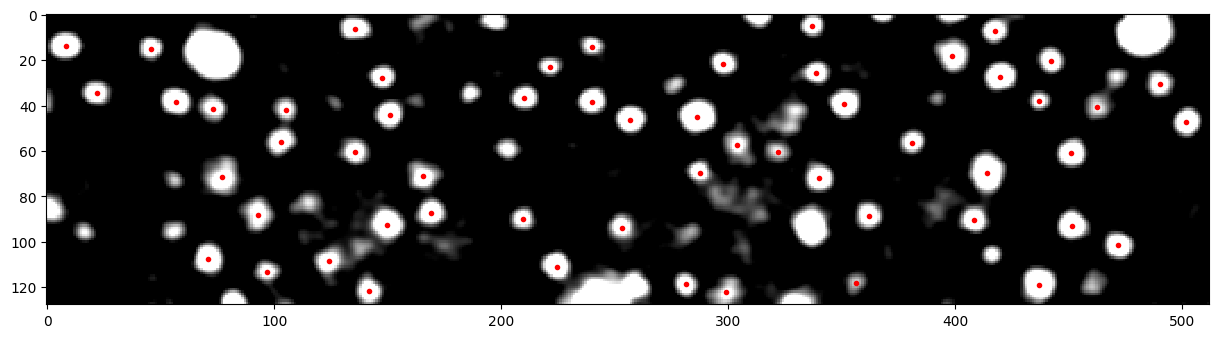

In [25]:
tp.annotate(features_modif[features_modif.frame==(0)], my_img[0], plot_style={'markersize':2});

In [26]:
# Bubble tracking
# we must specify a maximum displacement, the farthest an object can travel between frames (search_range)
# We allow for the possibility that an object might be missed for a few frames and then
# Memory keeps track of disappeared objects and maintains their ID for up to some number
# Here we use 5 frames.
# Note that the term particle refers to an object of interest.

search_range = 10
t = tp.link_df(features_modif, search_range, memory=5) # memory=5
t.head

Frame 20: 61 trajectories present.


<bound method NDFrame.head of              y           x  frame   area  brightness  particle
0   121.480769  141.634615      0  104.0  205.519231         0
0    41.550000   73.130000      0  100.0  187.650000         1
0    57.282828  303.757576      0   99.0  175.585859         2
0    69.803738  413.957944      0  214.0  217.322430         3
0    41.808219  104.958904      0   73.0  186.136986         4
..         ...         ...    ...    ...         ...       ...
0    54.098901  382.065934     20   91.0  219.956044        18
0    38.546667  254.666667     20  150.0  212.706667        41
0   103.233577   69.313869     20  137.0  218.678832        43
0   112.342593  127.935185     20  108.0  183.342593        14
0   119.312500  302.625000     20   80.0  150.687500        19

[1223 rows x 6 columns]>

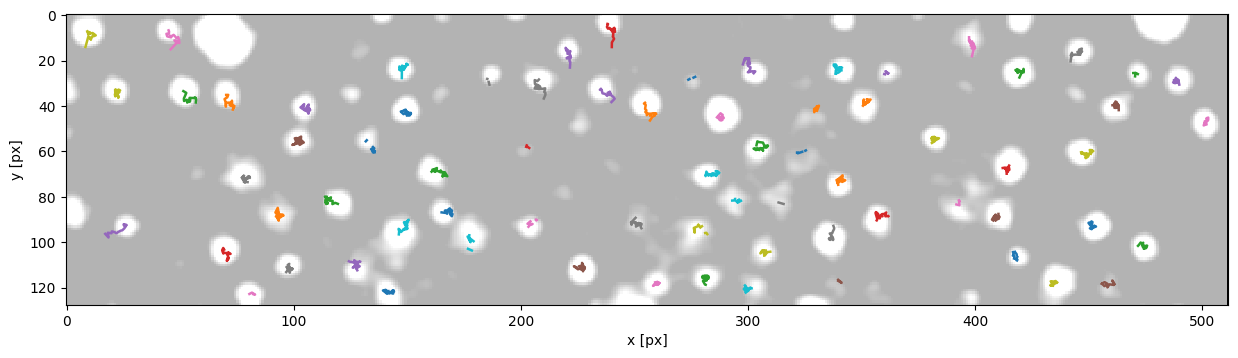

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [27]:
# plot trajectories

overlay = img.copy()
cv2.rectangle(overlay, (0, 0), (img.shape[1]-2, img.shape[0]), (255, 255, 255), -1)  # A filled rectangle
alpha = 0.7  # Transparency factor.
img_bkgr = cv2.addWeighted(overlay, alpha, img, 1-alpha, 0)

tp.plot_traj(t, superimpose=img_bkgr, plot_style={'linewidth': 1.8}) # remove the superimpose part to just plot the trajectories

In [30]:
# is there an overall drift? If so, we need to correct for it
drift = tp.compute_drift(t)

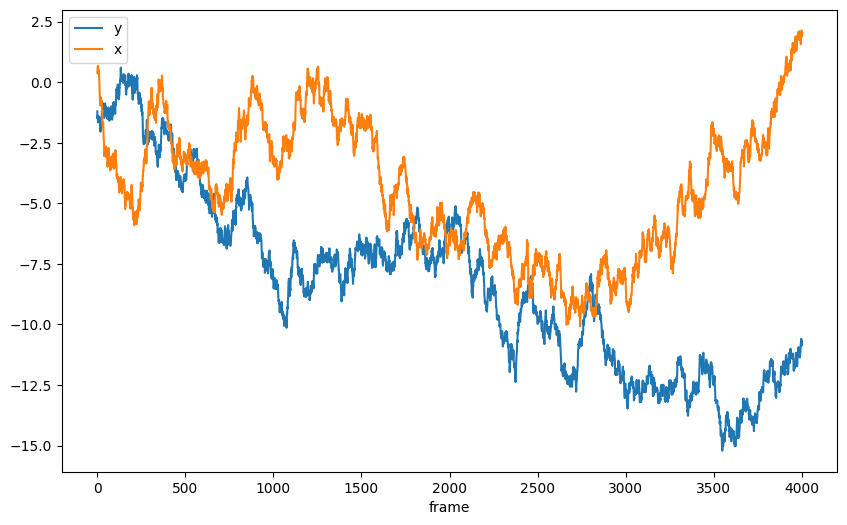

In [31]:
drift.plot(figsize=(10, 6)) # if there is a horizontal line, there is no drift
plt.show()

In [32]:
# correct drift
t_corrected = tp.subtract_drift(t.copy(), drift)

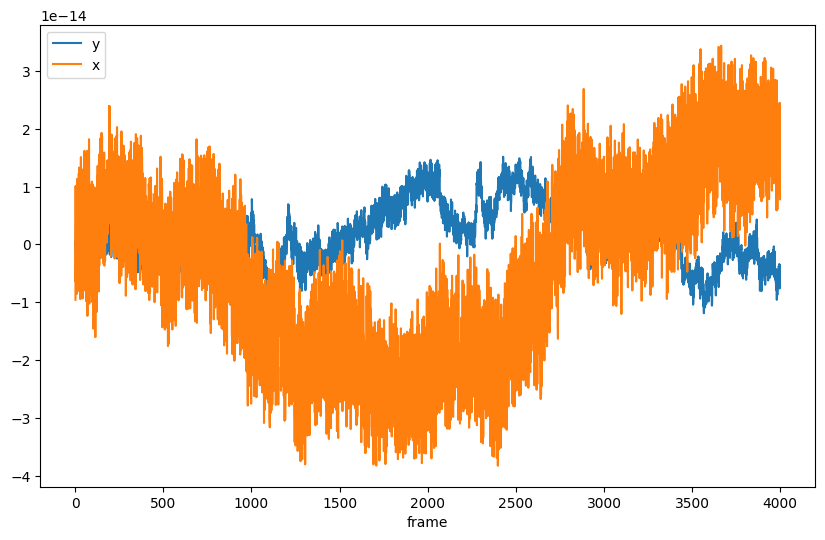

In [33]:
# plot drift plots one more to be sure it works well
drift = tp.compute_drift(t_corrected)

drift.plot(figsize=(10, 6)) # if there is a horizontal line, there is no drift
plt.show()

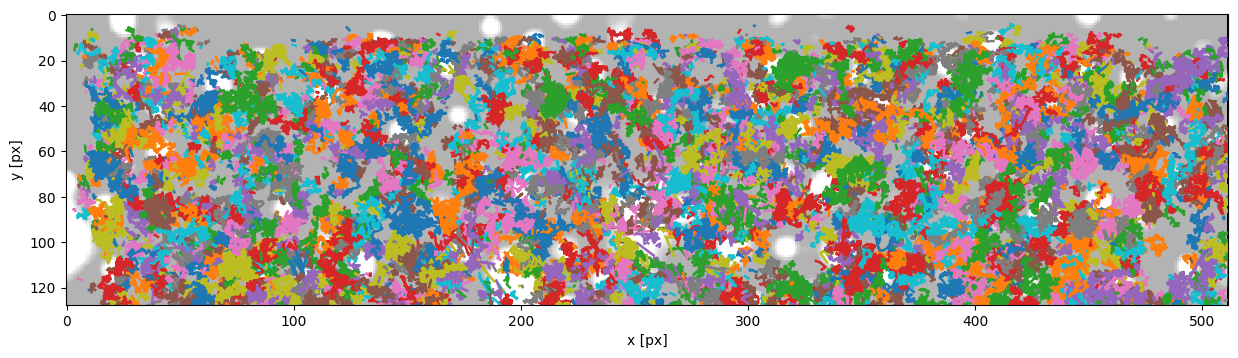

In [34]:
overlay = img.copy()
cv2.rectangle(overlay, (0, 0), (img.shape[1]-2, img.shape[0]), (255, 255, 255), -1)  # A filled rectangle
alpha = 0.7  # Transparency factor.
img_bkgr = cv2.addWeighted(overlay, alpha, img, 1-alpha, 0)

ax = tp.plot_traj(t_corrected, superimpose=img_bkgr, plot_style={'linewidth': 1.8})
plt.show()

In [35]:
t_corrected.to_csv('data_out/feb20_S5_t_corrected.csv', index=False)

In [36]:
# compute the mean squared displacement (MSD) of each particle using the imsd function, and plot MSD vs. lag time
# im = tp.imsd(t_corrected, 0.11073, 62.2, max_lagtime=622) # microns per pixel = 0.3069 (from Nikon reader (footer of the main window)), frames per second = 1.0 (1 frame per about 1 sec)

In [37]:
# fig, ax = plt.subplots(figsize=(10, 6))
# ax.plot(im.index, im, 'k-', alpha=0.1) # black lines, semitransparent
# ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
#       xlabel='lag time $t$')
# ax.set_xscale('log')
# ax.set_yscale('log')

In [46]:
# Ensemble Mean Squared Displacement

# !!! This doesn't work for the latest pandas version (2.0.3). Downgrade version to 1.5.3 (pip install pandas==1.5.3)

em = tp.emsd(t_corrected, 0.09207, 120., max_lagtime=5000)
# em = tp.emsd(t_corrected, 0.11073, 62.2, max_lagtime=622)

/Users/miroshni/anaconda3/lib/python3.11/site-packages/trackpy/motion.py:235: FutureWarning:

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().

/Users/miroshni/anaconda3/lib/python3.11/site-packages/trackpy/motion.py:236: FutureWarning:

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().



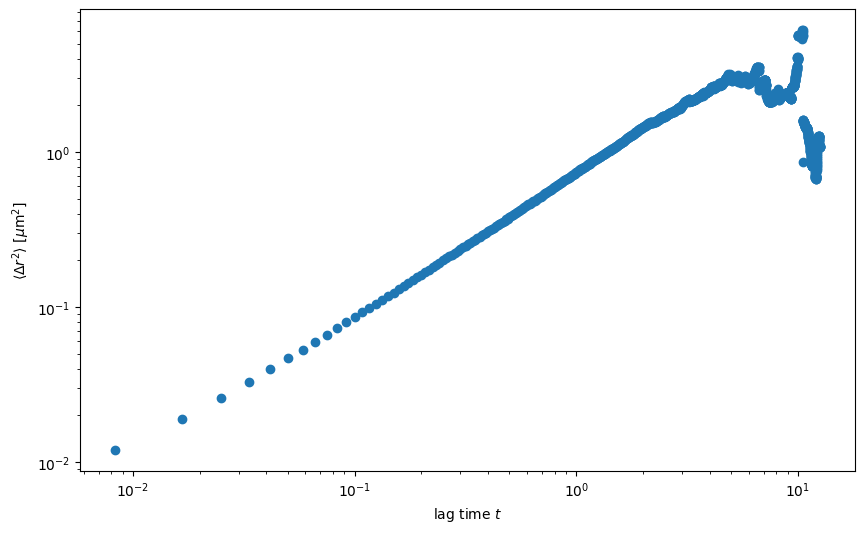

In [47]:
fig, ax = plt.subplots(figsize=(10, 6))
# ax.plot(im.index, im, 'o', color='red')
ax.plot(em.index, em, 'o')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
      xlabel='lag time $t$')
# ax.set_ylim(0.1, 100)
ax.set_xscale('log')
ax.set_yscale('log')

In [48]:
em.head

<bound method NDFrame.head of lagt
0.008333     0.011940
0.016667     0.019013
0.025000     0.026021
0.033333     0.032874
0.041667     0.039862
               ...   
12.525000    1.076127
12.533333    1.097452
12.541667    1.080217
12.550000    1.081583
12.558333    1.069553
Name: msd, Length: 1507, dtype: float64>

In [49]:
# write MSD in file

import csv

with open('data_out/feb20_S5_EMSD.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)#, delimiter='\t')
    writer.writerow(["lag time t", "dr^2"])
    writer.writerows(zip(em.index, em))

In [42]:
# Fit this ensemble mean-squared displacement to a power law. Linear regression in log space

# plt.figure(figsize=(10, 6))
# plt.ylabel=(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
# plt.xlabel=('lag time $t$')
# tp.utils.fit_powerlaw(em) #performs linear best fit in log space, plots

In [43]:
# test how dataframe 't_corrected' was written to file 

# f_corr = pd.read_csv('data_out/BE4-2D_4000frames/BE4-2D_t_corrected.csv')
# f_corr.head

In [44]:
# NOT corrected Ensemble Mean Squared Displacement

# em_notcor = tp.emsd(t, 0.3069, 1.0, max_lagtime=4000)

In [45]:
# fig, ax = plt.subplots(figsize=(10, 6))
# ax.plot(em_notcor.index, em_notcor, 'o')
# ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
#       xlabel='lag time $t$')
# # ax.set_ylim(0.1, 100)
# ax.set_xscale('log')
# ax.set_yscale('log')